In [1]:
!python3 --version

Python 3.12.12


In [2]:
!pip install -q kaggle tensorflow keras opencv-python

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tuantaquoc","key":"58e6c0435d1cfc7f30f6c7caf0bc772e"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download fatihkgg/affectnet-yolo-format
!unzip -q affectnet-yolo-format

Dataset URL: https://www.kaggle.com/datasets/fatihkgg/affectnet-yolo-format
License(s): MIT
 59% 153M/258M [00:00<00:00, 1.59GB/s]
100% 258M/258M [00:00<00:00, 947MB/s] 


In [6]:
!ls YOLO_format/

data.yaml  test  train	valid


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [8]:
emo_labels = {0:'angry', 1:'contempt', 2:'disgust', 3:'fear', 4:'happy', 5:'neutral', 6:'sad', 7:'surprise'}

In [9]:
def read_yolo_label(txt_path):
    try:
        with open(txt_path, 'r') as f:
            line = f.readline().strip().split()
            if len(line) < 5:
                return None
            label = int(line[0])
            bbox = list(map(float, line[1:5]))  # center_x, center_y, width, height
            return label, bbox
    except:
        return None

In [10]:
def crop_face(img, bbox):
    h, w = img.shape[:2]
    cx, cy, bw, bh = bbox
    cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h

    x1 = int(max(cx - bw / 2, 0))
    y1 = int(max(cy - bh / 2, 0))
    x2 = int(min(cx + bw / 2, w))
    y2 = int(min(cy + bh / 2, h))

    if x2 - x1 < 10 or y2 - y1 < 10:  # bounding box quá nhỏ
        return None

    return img[y1:y2, x1:x2]

In [11]:
def preprocess_dataset(image_dir, label_dir, target_size=(96, 96), max_count=None):
    X, y = [], []
    image_paths = sorted(glob(os.path.join(image_dir, '*.*')))
    for img_path in tqdm(image_paths[:max_count]):
        filename = os.path.basename(img_path).rsplit('.', 1)[0]
        label_path = os.path.join(label_dir, filename + '.txt')

        if not os.path.exists(label_path):
            continue

        result = read_yolo_label(label_path)
        if result is None:
            continue

        label, bbox = result
        img = cv2.imread(img_path)
        if img is None:
            continue

        face = crop_face(img, bbox)
        if face is None:
            continue

        face = cv2.resize(face, target_size)
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

        X.append(face)
        y.append(label)

    return np.array(X), np.array(y)

In [12]:
base_path = 'YOLO_format/'
train_img_dir = os.path.join(base_path, 'train/images')
train_label_dir = os.path.join(base_path, 'train/labels')
valid_img_dir = os.path.join(base_path, 'valid/images')
valid_label_dir = os.path.join(base_path, 'valid/labels')
test_img_dir = os.path.join(base_path, 'test/images')
test_label_dir = os.path.join(base_path, 'test/labels')

In [13]:
X_train, y_train = preprocess_dataset(train_img_dir, train_label_dir)
X_val, y_val = preprocess_dataset(valid_img_dir, valid_label_dir)
X_test, y_test = preprocess_dataset(test_img_dir, test_label_dir)

100%|██████████| 2755/2755 [00:01<00:00, 2521.15it/s]


In [14]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32)

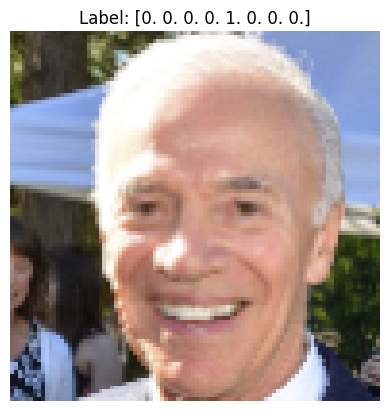

In [16]:
plt.imshow(X_train[5])
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Dense, GlobalAveragePooling2D, Activation, Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

model = tf.keras.models.Sequential()

# --- Feature Extraction ---
model.add(Input(shape=(96, 96, 3)))

# Block 1
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1)) # Drop ít ở các lớp đầu

# Block 2
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Block 3
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 4
model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 5
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# --- Classifier (Cải tiến lớn) ---

# Thay Flatten bằng Global Average Pooling
# Thay vì trải phẳng 3x3x512 = 4608 vector, nó lấy trung bình mỗi feature map -> vector 512
model.add(GlobalAveragePooling2D())

# Dense layers theo hình phễu
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(8, activation='softmax'))

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Learning rate này khá an toàn
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,739,336 (6.64 MB)

 Trainable params: 1,736,584 (6.62 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [18]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '':
    print(f'✅ GPU đã sẵn sàng: {device_name}')
else:
    print('❌ Không tìm thấy GPU. Hãy kiểm tra lại trong Runtime > Change runtime type.')

✅ GPU đã sẵn sàng: /device:GPU:0


In [19]:
class_weight = {
    0: 0.925,  # angry
    1: 1.028,  # contempt
    2: 1.028,  # disgust
    3: 1.233,  # fear
    4: 0.841,  # happy
    5: 1.028,  # neutral
    6: 0.925,  # sad
    7: 1.088   # surprise
}

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=150,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.1563 - loss: 2.2413 - val_accuracy: 0.2001 - val_loss: 2.0570 - learning_rate: 1.0000e-04
Epoch 2/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.1727 - loss: 2.1872 - val_accuracy: 0.1957 - val_loss: 2.0094 - learning_rate: 1.0000e-04
Epoch 3/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.1843 - loss: 2.1476 - val_accuracy: 0.1709 - val_loss: 2.2327 - learning_rate: 1.0000e-04
Epoch 4/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 45s 83ms/step - accuracy: 0.1979 - loss: 2.1005 - val_accuracy: 0.2717 - val_loss: 1.9095 - learning_rate: 1.0000e-04
Epoch 5/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.2274 - loss: 2.0493 - val_accuracy: 0.2978 - val_loss: 1.8485 - learning_rate: 1.0000e-04
Epoch 6/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 44s 83ms/step - accuracy: 0.2445 - loss: 2.0016 - val_accuracy: 0.2257 - val_loss: 2.1702 - learning_rate: 1.0000e-04
Epoch 7/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 43s 8

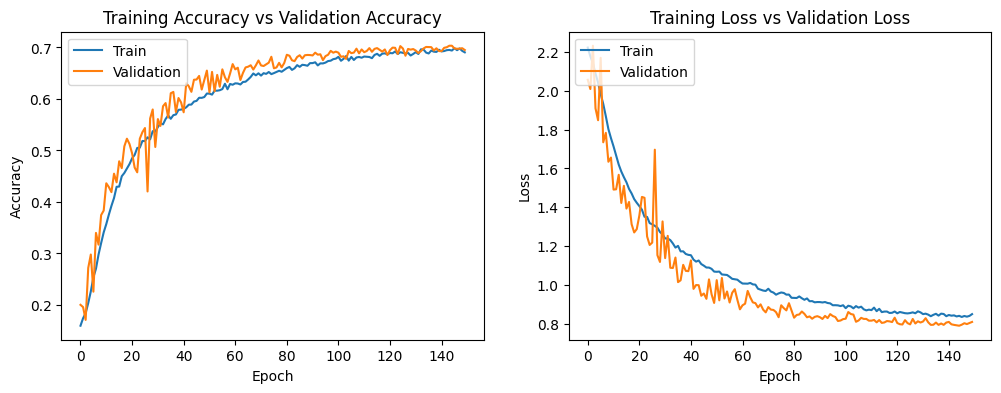

In [22]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [23]:
model.save('model_optimal.h5')


In [24]:
from google.colab import files
files.download('model_optimal.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
from tensorflow.keras.models import load_model

model = load_model('model_optimal.h5')

In [26]:
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
test_loss, test_acc = model.evaluate(test_generator, verbose=0)


In [27]:
print(f"Train Loss: {train_loss*100:.2f}, Train Accuracy: {train_acc*100:.2f}")
print(f"Validation Loss: {val_loss*100:.4f}, Validation Accuracy: {val_acc*100:.4f}")
print(f"Test Loss: {test_loss*100:.4f}, Test Accuracy: {test_acc*100:.4f}")

Train Loss: 57.52, Train Accuracy: 78.70
Validation Loss: 78.8705, Validation Accuracy: 70.3293
Test Loss: 79.8646, Test Accuracy: 70.7078


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


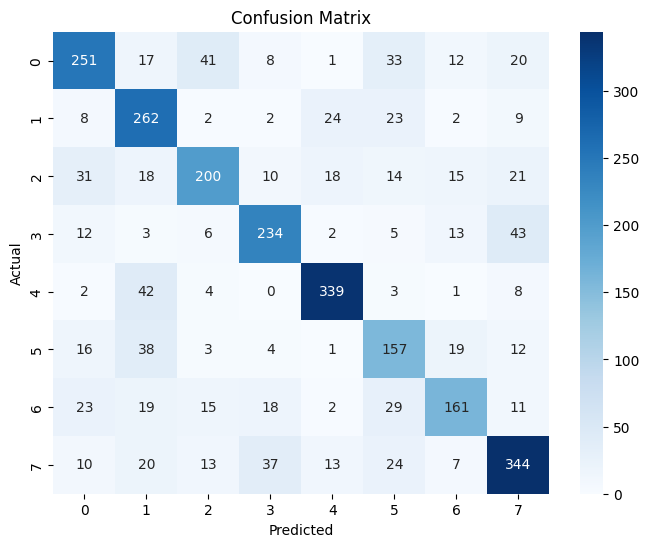


Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       383
           1       0.63      0.79      0.70       332
           2       0.70      0.61      0.65       327
           3       0.75      0.74      0.74       318
           4       0.85      0.85      0.85       399
           5       0.55      0.63      0.58       250
           6       0.70      0.58      0.63       278
           7       0.74      0.74      0.74       468

    accuracy                           0.71      2755
   macro avg       0.70      0.70      0.70      2755
weighted avg       0.71      0.71      0.71      2755



In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

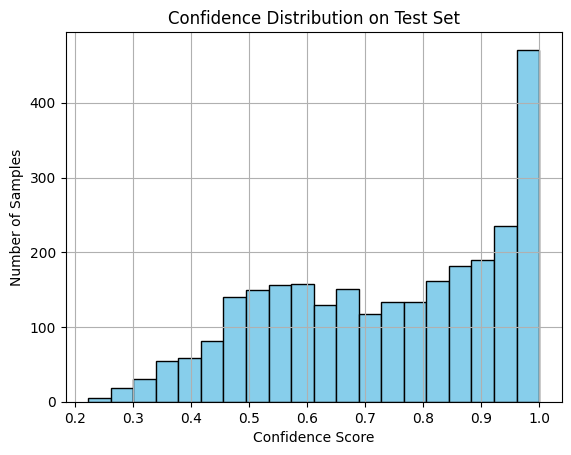

In [29]:
confidences = np.max(y_pred_probs, axis=1)

plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Confidence Score")
plt.ylabel("Number of Samples")
plt.title("Confidence Distribution on Test Set")
plt.grid(True)
plt.show()

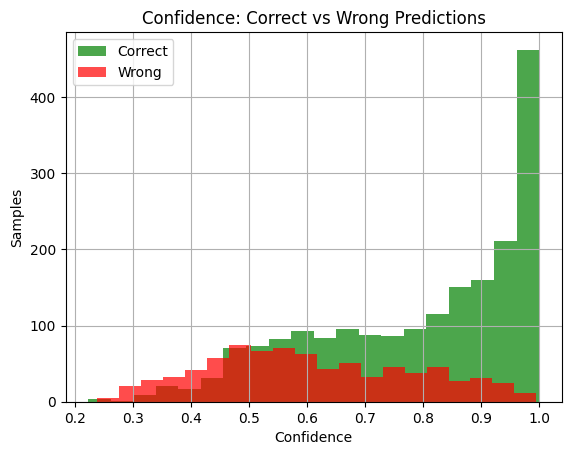

In [30]:
correct = (y_pred == y_true)

conf_correct = confidences[correct]
conf_wrong = confidences[~correct]

plt.hist(conf_correct, bins=20, alpha=0.7, label="Correct", color='green')
plt.hist(conf_wrong, bins=20, alpha=0.7, label="Wrong", color='red')
plt.xlabel("Confidence")
plt.ylabel("Samples")
plt.legend()
plt.title("Confidence: Correct vs Wrong Predictions")
plt.grid(True)
plt.show()

In [31]:
print(f"Mean confidence (correct): {np.mean(conf_correct):.2f}")
print(f"Mean confidence (wrong):   {np.mean(conf_wrong):.2f}")
print(f"Samples with confidence > 0.9: {np.sum(confidences > 0.9)}")
print(f"Wrong samples with confidence > 0.9: {np.sum(confidences > 0.8)}")
print(f"Samples with confidence < 0.5: {np.sum(confidences < 0.5)}")

Mean confidence (correct): 0.79
Mean confidence (wrong):   0.61
Samples with confidence > 0.9: 821
Wrong samples with confidence > 0.9: 1263
Samples with confidence < 0.5: 408


In [32]:
wrong_mask = (y_pred != y_true) & (confidences > 0.9)
wrong_indices = np.where(wrong_mask)[0]

In [ ]:
plt.figure(figsize=(15, 50))
for i, idx in enumerate(wrong_indices[:50]):
    plt.subplot(10, 5, i+1)
    img = X_test[idx]
    if img.max() <= 1.0:  # Nếu đã chuẩn hóa
        img = (img * 255).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {emo_labels[y_true[idx]]}\nPred: {emo_labels[y_pred[idx]]}\nConf: {confidences[idx]:.2f}")
plt.tight_layout()
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc   = model.evaluate(val_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, val_acc*100))

In [ ]:
test_loss, test_acc   = model.evaluate(test_generator)
print("final test accuracy = {:.2f}".format(test_acc*100))

In [ ]:
model.save_weights('model.weights.h5')